In [50]:
import config as cfg
import pandas as pd 
import geopandas as gpd
import numpy as np
import logging
# for plotting
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
# for Moran's I
from libpysal.weights import Queen, KNN
from esda.moran import Moran, Moran_Local
from libpysal.weights import lag_spatial

'''
Great source: https://geographicdata.science/book/notebooks/07_local_autocorrelation.html
'''

# READ DATA ------------------------------------------------------------------------------------------------------

merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') 
gdf = merged[['ID', 'geometry'] + cfg.INCOME_VARS_OF_INTEREST] # here I select the variable of interest
gdf = gdf.reset_index(drop=True) # reset the index to calculate the weights with no problems


In [51]:
gdf.head()

,ID,geometry,Media de la renta por unidad de consumo,Mediana de la renta por unidad de consumo,Renta bruta media por hogar,Renta bruta media por persona,Renta neta media por hogar,Renta neta media por persona
0,2807901,"POLYGON ((440598.916 4473021.501, 440521.387 4...",26.442,20.65,49.775,24.911,38.360,19.199
1,2807902,"POLYGON ((441868.35 4470574.975, 441687.915 44...",29.303,26.25,59.671,25.687,46.699,20.103
2,2807903,"POLYGON ((443284.243 4472327.462, 443199.459 4...",35.706,30.45,75.689,31.523,57.448,23.925
3,2807904,"POLYGON ((441815.427 4474666.996, 441573.366 4...",39.424,29.75,82.900,35.734,60.217,25.956
4,2807905,"POLYGON ((443449.166 4477025.984, 443310.072 4...",43.930,32.55,97.093,39.346,69.670,28.233


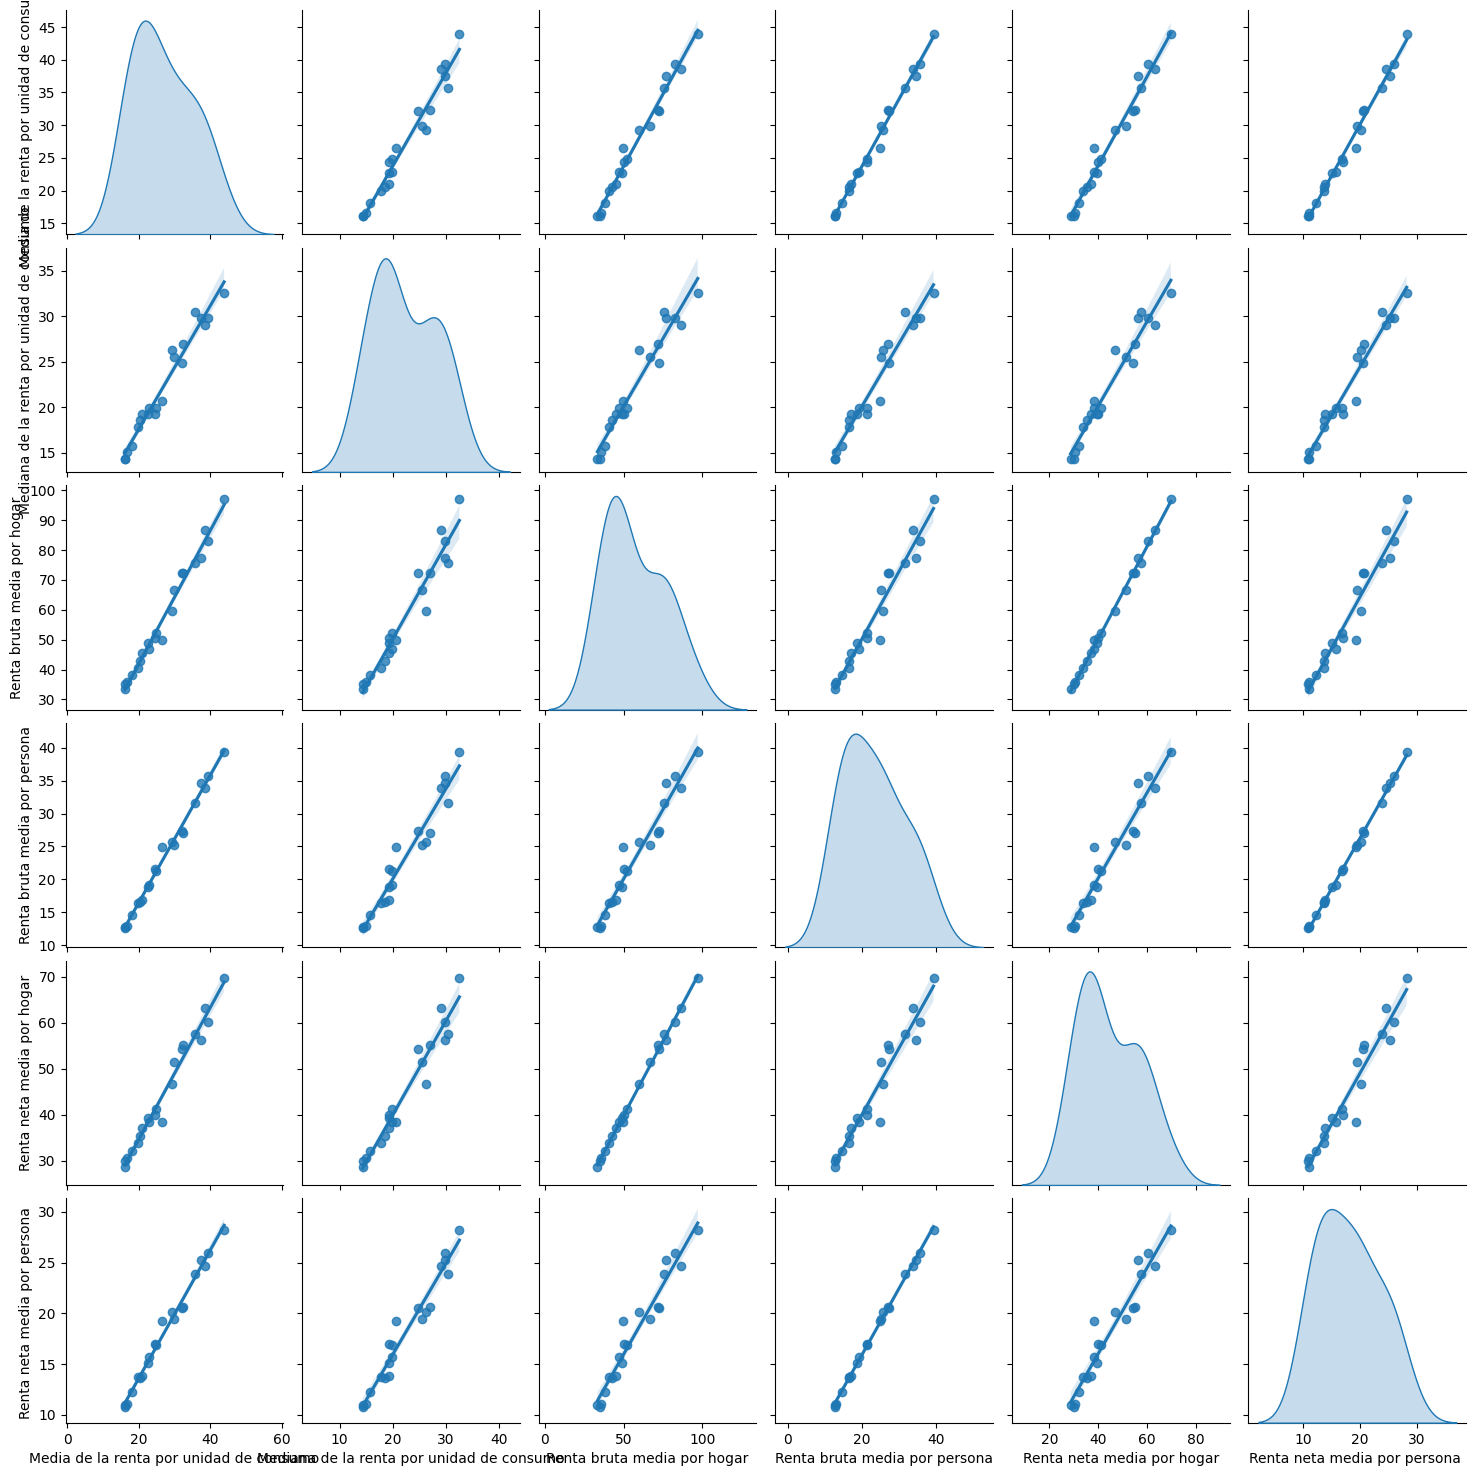

In [52]:
_ = sns.pairplot(
    gdf[cfg.INCOME_VARS_OF_INTEREST], kind="reg", diag_kind="kde"
)

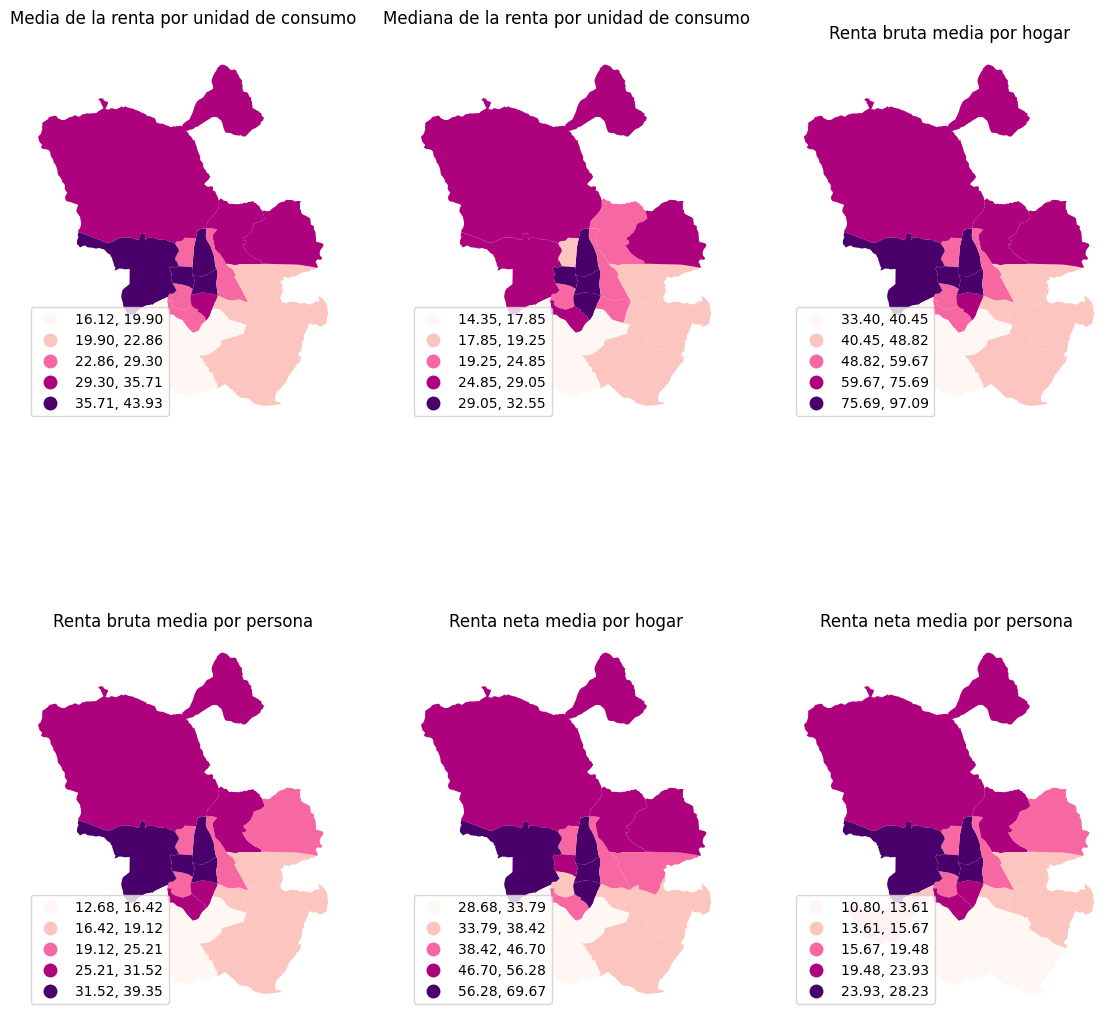

In [53]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 14))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cfg.INCOME_VARS_OF_INTEREST):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        k=5, # n quantiles
        legend=True,
        legend_kwds={"loc": "lower left"},
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

if cfg.SAVE_FIGURES:
    f.savefig(cfg.FIGURES_PATH / 'income_quantiles.png', dpi=300, bbox_inches='tight')

In [54]:
w = Queen.from_dataframe(gdf)

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_30873/38079147.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


In [42]:
# w = KNN.from_dataframe(gdf, k=4)

In [55]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(gdf[variable], w) for variable in cfg.INCOME_VARS_OF_INTEREST
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cfg.INCOME_VARS_OF_INTEREST, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
Media de la renta por unidad de consumo,0.417235,0.001
Mediana de la renta por unidad de consumo,0.314509,0.006
Renta bruta media por hogar,0.369917,0.001
Renta bruta media por persona,0.452832,0.003
Renta neta media por hogar,0.358033,0.004
Renta neta media por persona,0.459382,0.001


In [56]:
# CALCULATE GLOBAL MORAN'S I STATS FOR EACH VARIABLE OF INTEREST ---------------------------------------------------------------------------------------------
import numpy as np
np.random.seed(123456)

# Calculate Moran's I for each variable
global_mi = [
    Moran(gdf[variable], w) for variable in cfg.INCOME_VARS_OF_INTEREST
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim, res.z_sim)
    for variable, res in zip(cfg.INCOME_VARS_OF_INTEREST, global_mi)
]

global_moran = pd.DataFrame(
    mi_results, columns=["Variable", "Morans I", "P-value", "Z-Score"]
).set_index("Variable")

In [57]:

# CALCULATE LOCAL MORAN'S I STATS FOR EACH VARIABLE OF INTEREST ---------------------------------------------------------------------------------------------


local_mi = [
    Moran_Local(gdf[variable], w) for variable in cfg.INCOME_VARS_OF_INTEREST
]

mi_results_local = [
    (variable, res.Is, res.p_sim, res.z_sim, res.q)
    for variable, res in zip(cfg.INCOME_VARS_OF_INTEREST, local_mi)
]

local_moran = pd.DataFrame(
    mi_results_local, columns=["Variable", "Local Morans I","P-value", "Z-Score",  "Quadrant"]
).set_index("Variable")




In [58]:
local_moran

,Local Morans I,P-value,Z-Score,Quadrant
Variable,,,,
Media de la renta por unidad de consumo,"[-0.05563024345796248, -0.15604025407240216, 0...","[0.017, 0.047, 0.371, 0.025, 0.016, 0.004, 0.0...","[-2.166379753200696, -1.6140719938038355, 0.31...","[2, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Mediana de la renta por unidad de consumo,"[-0.24177333137168427, -0.3959099602765927, 0....","[0.018, 0.052, 0.361, 0.04, 0.049, 0.008, 0.04...","[-2.3295019297821673, -1.6078980630662598, 0.3...","[2, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Renta bruta media por hogar,"[-0.2790258145659181, -0.06974526333005861, -0...","[0.034, 0.028, 0.483, 0.064, 0.018, 0.002, 0.0...","[-1.8821903406448082, -1.9012700141484127, -0....","[2, 4, 4, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Renta bruta media por persona,"[0.15453979721081815, -0.1596219343306181, 0.0...","[0.013, 0.06, 0.368, 0.018, 0.019, 0.002, 0.00...","[2.205300912839857, -1.5581241305500406, 0.321...","[1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Renta neta media por hogar,"[-0.3499393741220844, -0.10531364823997524, -0...","[0.027, 0.026, 0.479, 0.06, 0.017, 0.002, 0.01...","[-1.9009130546808677, -1.838220584778622, 0.03...","[2, 4, 4, 1, 1, 2, 1, 1, 4, 2, 3, 3, 3, 2, 2, ..."
Renta neta media por persona,"[0.1696128806504696, -0.20765754351655485, 0.0...","[0.012, 0.074, 0.345, 0.016, 0.023, 0.002, 0.0...","[2.225276251950631, -1.5348159641319021, 0.430...","[1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."


In [59]:
global_moran

,Morans I,P-value,Z-Score
Variable,,,
Media de la renta por unidad de consumo,0.417235,0.001,3.813768
Mediana de la renta por unidad de consumo,0.314509,0.006,2.755427
Renta bruta media por hogar,0.369917,0.001,3.441087
Renta bruta media por persona,0.452832,0.003,3.955561
Renta neta media por hogar,0.358033,0.004,3.298673
Renta neta media por persona,0.459382,0.001,4.017533


In [74]:
gdf['Media de la renta por unidad de consumo']

0     26.442
1     29.303
2     35.706
3     39.424
4     43.930
5     24.442
6     37.509
7     32.322
8     38.543
9     19.903
10    18.120
11    16.165
12    16.116
13    22.856
14    24.874
15    32.206
16    16.590
17    20.469
18    20.948
19    22.694
20    29.915
Name: Media de la renta por unidad de consumo, dtype: float64

In [77]:
moran_mc_r = [
    Moran(gdf[variable], w, permutations=1999) for variable in cfg.INCOME_VARS_OF_INTEREST
]

for variable, moran_mc in zip(cfg.INCOME_VARS_OF_INTEREST, moran_mc_r):
    print(f"Results for {variable}:")
    print(f"Moran's I: {moran_mc.I}")
    print(f"P-value: {moran_mc.p_sim}")
    print("-" * 40)

Results for Media de la renta por unidad de consumo:
Moran's I: 0.41723477039892676
P-value: 0.0025
----------------------------------------
Results for Mediana de la renta por unidad de consumo:
Moran's I: 0.31450934235692213
P-value: 0.0065
----------------------------------------
Results for Renta bruta media por hogar:
Moran's I: 0.3699172618508335
P-value: 0.004
----------------------------------------
Results for Renta bruta media por persona:
Moran's I: 0.4528315259653595
P-value: 0.0005
----------------------------------------
Results for Renta neta media por hogar:
Moran's I: 0.3580327301096283
P-value: 0.004
----------------------------------------
Results for Renta neta media por persona :
Moran's I: 0.45938152328809306
P-value: 0.0005
----------------------------------------
